In [2]:
from google.colab import drive

import numpy as np
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim

import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Normalize, Compose

from torch.utils.data import TensorDataset, DataLoader

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_path = '/content/drive/My Drive/100/'
os.chdir(dataset_path)

In [4]:
!tar -xvzf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [5]:
os.listdir('.')

['cifar-10-python.tar.gz', 'cifar-10-batches-py']

In [6]:
def unpickle(file):
    with open(f'cifar-10-batches-py/{file}', 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [7]:
train_data = []
train_labels = []

# Load and append all training batches
for i in range(1, 6):
    batch = unpickle(f'data_batch_{i}')
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']

# Convert lists to numpy arrays for convenience
train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
train_labels = np.array(train_labels)

# Load the test batch
test_batch = unpickle('test_batch')
test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_labels = np.array(test_batch[b'labels'])

In [8]:
print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


## DataLoader Task 1

In [9]:
train_data_tensor = torch.tensor(train_data.transpose((0, 3, 1, 2)), dtype=torch.float) / 255.0
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_data_tensor = torch.tensor(test_data.transpose((0, 3, 1, 2)), dtype=torch.float) / 255.0
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_data_tensor = (train_data_tensor - 0.5) / 0.5
test_data_tensor = (test_data_tensor - 0.5) / 0.5

train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [20]:
# Fetch the first batch from the train_loader
first_batch_inputs, first_batch_labels = next(iter(train_loader))
print(f"Shape of the inputs in the first batch: {first_batch_inputs.shape}")
# Expected output: Shape of the inputs in the first batch: torch.Size([64, 3, 32, 32])


Shape of the inputs in the first batch: torch.Size([64, 3, 32, 32])


Batch images shape: torch.Size([64, 3, 32, 32])
Batch labels shape: torch.Size([64])


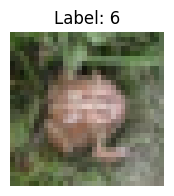

In [10]:
images, labels = next(iter(train_loader))

print(f"Batch images shape: {images.shape}")
print(f"Batch labels shape: {labels.shape}")

# Visualize the first image in the batch
plt.figure(figsize=(2, 2))
plt.imshow(images[0].permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize
plt.title(f"Label: {labels[0]}")
plt.axis('off')
plt.show()

In [10]:
# class IntermediateBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, num_convs=3):
#         super(IntermediateBlock, self).__init__()
#         # Define L independent convolutional layers.
#         self.convs = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1) for _ in range(num_convs)])
#         # Fully connected layer to compute weights from the input's channel means.
#         self.fc = nn.Linear(in_channels, num_convs)

#     def forward(self, x):
#         # Compute the mean of each input channel.
#         channel_means = x.mean([-2, -1])
#         # Obtain weights for combining convolutional outputs.
#         weights = F.softmax(self.fc(channel_means), dim=1)
#         # Combine the convolutional layers' outputs according to computed weights.
#         conv_outputs = torch.stack([conv(x) for conv in self.convs], dim=1)
#         output = torch.sum(weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) * conv_outputs, dim=1)
#         return output

# class OutputBlock(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         super(OutputBlock, self).__init__()
#         # Global average pooling to reduce each channel to a single value.
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         # Fully connected layer(s) to produce the logits from averaged channel values.
#         self.fc = nn.Linear(in_channels, num_classes)

#     def forward(self, x):
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.fc(x)
#         return x

# class CIFAR10Classifier(nn.Module):
#     def __init__(self, num_blocks=2, in_channels=3, num_classes=10):
#         super(CIFAR10Classifier, self).__init__()
#         # Sequentially add intermediate blocks with increasing channels.
#         self.blocks = nn.Sequential()
#         out_channels = 64  # Adjust based on performance and complexity needs.
#         for i in range(num_blocks):
#             self.blocks.add_module(f"block_{i+1}", IntermediateBlock(in_channels if i == 0 else out_channels, out_channels))
#         # Output block to produce final classification logits.
#         self.output_block = OutputBlock(out_channels, num_classes)

#     def forward(self, x):
#         # Process input through intermediate blocks and output block.
#         x = self.blocks(x)
#         logits = self.output_block(x)
#         return logits

# # Initialize the model and print its architecture.
# model = CIFAR10Classifier()
# print(model)

In [11]:
# model = model.to('cuda')

In [17]:
import torch
from torch import nn
import torch.nn.functional as F

class ImprovedIntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs=3):
        super(ImprovedIntermediateBlock, self).__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            ) for i in range(num_convs)
        ])
        self.fc = nn.Linear(in_channels, num_convs)

    def forward(self, x):
        channel_means = x.mean([-2, -1])
        weights = F.softmax(self.fc(channel_means), dim=1)
        conv_outputs = torch.stack([conv(x) for conv in self.convs], dim=1)
        output = torch.sum(weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) * conv_outputs, dim=1)
        return output

class EnhancedOutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(EnhancedOutputBlock, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_channels, in_channels // 2)
        self.fc2 = nn.Linear(in_channels // 2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class CIFAR10Classifier(nn.Module):
    def __init__(self, num_blocks=2, num_classes=10):
        super(CIFAR10Classifier, self).__init__()
        self.blocks = nn.Sequential()
        in_channels = 3
        out_channels = 64
        for i in range(num_blocks):
            self.blocks.add_module(f"block_{i+1}", ImprovedIntermediateBlock(in_channels, out_channels))
            in_channels = out_channels

        self.output_block = EnhancedOutputBlock(out_channels, num_classes)

    def forward(self, x):
        x = self.blocks(x)
        logits = self.output_block(x)
        return logits

model2 = CIFAR10Classifier()

print(model2)

CIFAR10Classifier(
  (blocks): Sequential(
    (block_1): ImprovedIntermediateBlock(
      (convs): ModuleList(
        (0): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout2d(p=0.2, inplace=False)
        )
        (1-2): 2 x Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout2d(p=0.2, inplace=False)
        )
      )
      (fc): Linear(in_features=3, out_features=3, bias=True)
    )
    (block_2): ImprovedIntermediateBlock(
      (convs): ModuleList(
        (0-2): 3 x Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [19]:
import torch.optim as optim
import time
import matplotlib.pyplot as plt

# Assuming `model2` is your CIFAR10Classifier instance and is already defined
model2.to(device)
optimizer = optim.Adam(model2.parameters(), lr=0.001)  # Adjust learning rate as needed
criterion = nn.CrossEntropyLoss()

# Placeholder for dynamic plotting (simplified version)
losses = []
def update_plot(epoch, loss):
    losses.append(loss)
    plt.plot(losses, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.pause(0.001)

num_epochs = 10  # Adjust number of epochs as needed

for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    running_loss = 0.0
    total_batches = 0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_batches += 1

    avg_loss = running_loss / total_batches
    update_plot(epoch, avg_loss)  # Update plot with average loss for this epoch
    elapsed_time = time.time() - start_time

    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch {epoch}/{num_epochs} - Loss: {avg_loss:.4f} - Time: {elapsed_time:.2f}s')

plt.show()  # Make sure to display the plot at the end


RuntimeError: Given groups=1, weight of size [64, 64, 3, 3], expected input[64, 3, 32, 32] to have 64 channels, but got 3 channels instead

In [13]:
# import torch.optim as optim

# criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001

In [14]:
# num_epochs = 20  # Number of epochs to train for

# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data[0].to('cuda'), data[1].to('cuda')

#         optimizer.zero_grad()  # Zero the parameter gradients

#         outputs = model(inputs)  # Forward pass
#         loss = criterion(outputs, labels)  # Compute loss
#         loss.backward()  # Backward pass
#         optimizer.step()  # Optimize

#         running_loss += loss.item()
#         if i % 2000 == 1999:  # Print average loss every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training')

In [15]:
# correct = 0
# total = 0
# with torch.no_grad():  # No need to compute gradient during evaluation
#     for data in test_loader:
#         images, labels = data[0].to('cuda'), data[1].to('cuda')
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print('Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct / total))


In [16]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model2 = CIFAR10Classifier().to(device)

# learning_rate = 0.001
# num_epochs = 30
# criterion = nn.CrossEntropyLoss().to(device)
# optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(num_epochs):
#     model2.train()
#     running_loss = 0.0
#     correct, total = 0, 0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model2(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
#           f'Accuracy: {100 * correct / total:.2f}%')

# # Evaluation
# model2.eval()
# correct, total = 0, 0
# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model2(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Test Accuracy: {100 * correct / total:.2f}%')

In [17]:
# # Assuming the necessary imports are already in place

# # Hyperparameters
# learning_rate = 0.001
# batch_size = 64  # Ensure this matches DataLoader configuration
# num_epochs = 30

# # Model, Loss, and Optimizer
# model2 = CIFAR10Classifier().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

# # Training Loop
# for epoch in range(num_epochs):
#     model2.train()
#     total_loss = 0
#     correct = 0
#     total = 0

#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model2(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, '
#           f'Accuracy: {correct/total:.4f}')

# # Evaluation
# model2.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model2(images)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Test Accuracy: {correct/total:.4f}')

